In [25]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print(f'Train data shape: {X_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')
print(f'dev data shape: {X_dev.shape}')
print(f'dev labels shape: {y_dev.shape}')

Train data shape: (49000, 3073)
Train labels shape: (49000,)
Validation data shape: (1000, 3073)
Validation labels shape: (1000,)
Test data shape: (1000, 3073)
Test labels shape: (1000,)
dev data shape: (500, 3073)
dev labels shape: (500,)


In [27]:
from classifiers.softmax import softmax_loss_naive
import time

W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

print(f'loss: {loss}')
print(f'sanity check: {-np.log(0.1)}')

loss: 2.364594428437469
sanity check: 2.3025850929940455


In [28]:
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.3178782330379732 analytic: -2.3178782511436498, relative error: 3.905657377688959e-09
numerical: -0.2205956330048053 analytic: -0.22059568821127715, relative error: 1.2513045743117198e-07
numerical: 0.6966961276555493 analytic: 0.6966962076035381, relative error: 5.737650966041798e-08
numerical: -1.0744082530322885 analytic: -1.0744083511788252, relative error: 4.5674692052952633e-08
numerical: -1.4176554248734872 analytic: -1.4176553526209998, relative error: 2.5483092682453688e-08
numerical: 0.5090584782596608 analytic: 0.50905826337654, relative error: 2.110594119061895e-07
numerical: -2.458033952978944 analytic: -2.4580338713893113, relative error: 1.659652302257586e-08
numerical: 2.4450178147228385 analytic: 2.445017731703698, relative error: 1.6977205924755413e-08
numerical: -1.733720188257237 analytic: -1.733720257943591, relative error: 2.0097347049451745e-08
numerical: -0.4120403624296997 analytic: -0.4120404070203994, relative error: 5.410962291713494e-08
numeri

In [29]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print(f'naive loss: {loss_naive} computed in {toc - tic}s')

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print(f'vectorized loss: {loss_vectorized} computed in {toc - tic}s')

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print(f'Loss difference: {np.abs(loss_naive - loss_vectorized)}')
print(f'Gradient difference: {grad_difference}')

naive loss: 2.364594429980531 computed in 0.03637194633483887s
vectorized loss: 2.36459442998053 computed in 0.003108978271484375s
Loss difference: 8.881784197001252e-16
Gradient difference: 2.376990039855451e-13


In [30]:
from classifiers.linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                                  num_iters=1500)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print(f'lr {lr} reg {reg} train accuracy {train_accuracy} val accuracy {val_accuracy}')

print(f'best validation accuracy achieved during cross-validation: {best_val}')




/Users/abhishekmishra/Documents/Courses/CS231n/CS231n_winter2016_py3/classifiers/softmax.py:90: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(correct_probs))
/Users/abhishekmishra/Documents/Courses/CS231n/CS231n_winter2016_py3/classifiers/softmax.py:92: RuntimeWarning: overflow encountered in scalar multiply
  loss += 0.5 * reg * np.sum(W * W)
/Users/abhishekmishra/anaconda3/envs/cs231n/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/abhishekmishra/Documents/Courses/CS231n/CS231n_winter2016_py3/classifiers/softmax.py:92: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)
/Users/abhishekmishra/Documents/Courses/CS231n/CS231n_winter2016_py3/classifiers/softmax.py:99: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


lr 1e-07 reg 50000.0 train accuracy 0.3305102040816327 val accuracy 0.339
lr 1e-07 reg 100000000.0 train accuracy 0.10026530612244898 val accuracy 0.087
lr 5e-07 reg 50000.0 train accuracy 0.3262244897959184 val accuracy 0.347
lr 5e-07 reg 100000000.0 train accuracy 0.10026530612244898 val accuracy 0.087
best validation accuracy achieved during cross-validation: 0.347


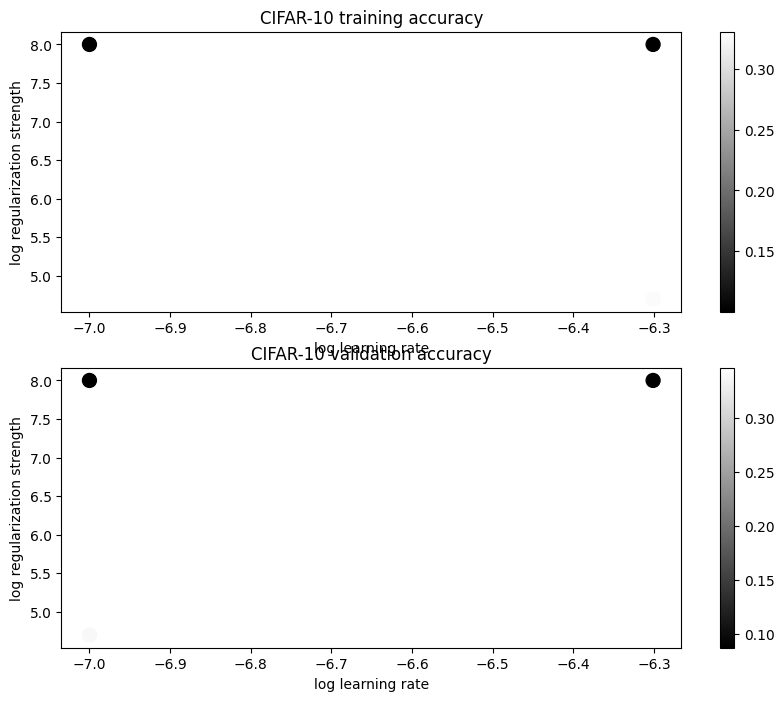

In [31]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]

plt.subplot(2,1,1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

colors = [results[x][1] for x in results]
plt.subplot(2,1,2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [33]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print(f'linear SVM on raw pixels final test set accuracy {test_accuracy}')

linear SVM on raw pixels final test set accuracy 0.343


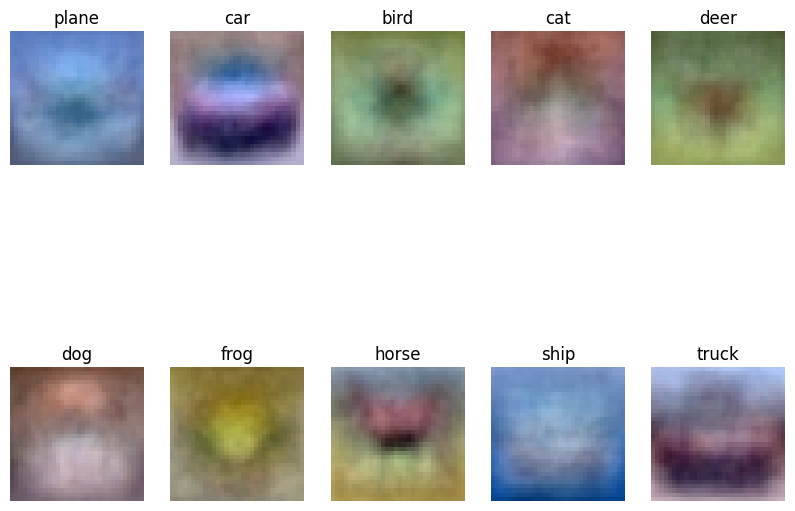

In [35]:
w = best_softmax.W[:-1,:]
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i+1)

    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [12]:
W = np.random.randn(3073, 10) * 0.0001
dW = np.zeros_like(W)
X = X_dev
y = y_dev
reg = 0.0
loss = 0.0
W.shape, dW.shape, X.shape, y.shape, reg


((3073, 10), (3073, 10), (500, 3073), (500,), 0.0)

In [13]:
scores = X @ W
scores_exp = np.exp(scores)
scores_exp_sum = np.sum(scores_exp, axis=1, keepdims=True)
probs = scores_exp / scores_exp_sum
logits = np.log(probs)
neg_log_likelihood = np.array([-logits[j, ix] for j, ix in enumerate(y)])
loss = np.mean(neg_log_likelihood)

In [15]:
probs.shape, y.shape

((500, 10), (500,))

In [16]:
probs_modified = np.copy(probs)
probs_modified[(np.arange(X.shape[0]), y)] -= 1

In [17]:
probs_modified

array([[ 0.05456253,  0.09991456,  0.14727921, ...,  0.05295993,
         0.11782037, -0.92403343],
       [ 0.07377477,  0.11881139,  0.08734791, ...,  0.16597461,
        -0.93636719,  0.08845061],
       [ 0.06436092,  0.09035487,  0.11227243, ...,  0.09643984,
         0.09268782,  0.10520632],
       ...,
       [ 0.06752371,  0.09233867,  0.0926729 , ...,  0.1016236 ,
        -0.8173338 ,  0.09169354],
       [ 0.06653315,  0.09669545,  0.07207643, ...,  0.098208  ,
         0.1115401 ,  0.07550665],
       [ 0.13588322,  0.08260253,  0.09913895, ...,  0.08206087,
         0.04785059,  0.12005497]])

In [46]:
loss

2.3936261623926063

In [43]:
np.min(neg_log_likelihood), np.max(neg_log_likelihood)

(1.4087973520628199, 3.3835804863571703)

In [44]:
neg_log_likelihood.shape

(500,)

In [38]:
scores.shape, scores_exp.shape, scores_exp_sum.shape, probs.shape, logits.shape

((500, 10), (500, 10), (500, 1), (500, 10), (500, 10))

In [34]:
np.array([-scores[j , ix] for j, ix in enumerate(y)])

array([-0.21842301,  0.25445247,  0.00663754,  0.13118509,  0.60048141,
        0.57362847,  0.05328411,  0.74267657,  0.35342989, -0.32122771,
        0.09331664,  0.23712906, -0.51312383, -0.5066684 , -0.0113677 ,
        0.03505479, -0.07842942,  0.43026046, -0.25426519,  0.28248915,
        0.21280678,  0.63963468,  0.57299422,  0.3780496 ,  0.35501605,
        0.07272124,  0.23906454, -0.1460519 ,  0.23825891, -0.15365037,
        0.11855421,  0.04300214, -0.33776471,  0.23579276, -0.19320663,
       -0.36613024,  0.03671847,  0.41466559,  0.41409344, -0.24512286,
        0.08548299,  0.65693476,  0.15275922,  0.01713354,  0.22739763,
        0.19851651, -0.28482269, -0.09901684, -0.12078433,  0.30754718,
        0.37711528,  0.33452754, -0.44453708,  0.7388792 ,  0.24185872,
       -0.07886372,  0.22753729,  0.17441156, -0.2474662 , -0.01317733,
       -0.60713541, -0.1237211 ,  0.12279482,  0.07326189, -0.00883999,
       -0.37758596,  0.19849227,  0.10315358,  0.75757367,  0.16

In [23]:
y

array([7, 2, 6, 4, 7, 1, 1, 8, 8, 9, 6, 8, 3, 8, 3, 9, 7, 9, 9, 4, 5, 5,
       4, 2, 1, 5, 2, 7, 3, 4, 3, 5, 6, 5, 5, 2, 0, 7, 4, 7, 4, 0, 8, 9,
       8, 6, 4, 1, 1, 9, 5, 9, 3, 1, 9, 8, 6, 0, 7, 9, 2, 6, 1, 1, 8, 7,
       1, 0, 2, 6, 0, 9, 7, 3, 3, 8, 5, 2, 2, 5, 6, 3, 5, 5, 1, 2, 7, 5,
       5, 4, 0, 4, 3, 3, 5, 5, 4, 3, 2, 8, 2, 4, 0, 5, 7, 7, 4, 4, 8, 3,
       5, 6, 3, 3, 3, 6, 4, 7, 8, 0, 3, 9, 5, 9, 7, 7, 2, 6, 2, 1, 2, 1,
       4, 9, 6, 3, 1, 7, 3, 3, 9, 3, 7, 1, 4, 1, 9, 2, 2, 5, 7, 8, 4, 3,
       7, 0, 2, 9, 5, 8, 5, 8, 5, 8, 1, 7, 9, 0, 5, 7, 9, 6, 0, 2, 5, 1,
       5, 7, 0, 2, 1, 5, 5, 5, 1, 0, 3, 4, 1, 6, 4, 8, 6, 9, 8, 0, 6, 7,
       5, 4, 4, 9, 0, 3, 9, 8, 2, 9, 9, 3, 8, 1, 6, 2, 5, 0, 5, 9, 4, 4,
       2, 2, 0, 8, 0, 3, 5, 1, 4, 6, 1, 4, 1, 7, 2, 9, 1, 4, 5, 2, 0, 9,
       5, 3, 2, 7, 7, 1, 8, 2, 5, 7, 5, 7, 4, 6, 5, 5, 2, 1, 7, 7, 7, 1,
       4, 0, 8, 5, 5, 5, 7, 6, 4, 9, 0, 3, 9, 2, 5, 5, 9, 6, 8, 4, 4, 6,
       9, 2, 3, 1, 2, 9, 6, 2, 8, 5, 8, 7, 8, 8, 2,

In [18]:
scores.shape, log_prob.shape, log_prob_sum.shape, logits.shape

((500, 10), (500, 10), (500, 1), (500, 10))

In [22]:
logits.sum(0)

array([50.63093888, 50.47916544, 51.57684415, 49.14396521, 52.1148448 ,
       48.6406907 , 50.31025324, 48.60788482, 49.26875886, 49.22665391])

In [ ]:
scores_sum = n

In [5]:
a = np.random.randint(0, 3, (3,4))
a

array([[1, 1, 0, 0],
       [1, 2, 0, 2],
       [1, 2, 0, 2]])

In [28]:
i = [2, 3, 3]
[a[j, ix] for j, ix in enumerate(i)]

[0, 2, 2]

In [30]:
a[:, i]

array([[0, 0, 0],
       [0, 2, 2],
       [0, 2, 2]])

In [27]:
a[2, 3]

2

In [12]:
a_sum = np.sum(a, axis = 1, keepdims=True)
a_sum

array([[2],
       [5],
       [5]])

In [13]:
a.shape, a_sum.shape

((3, 4), (3, 1))

In [14]:
a / a_sum

array([[0.5, 0.5, 0. , 0. ],
       [0.2, 0.4, 0. , 0.4],
       [0.2, 0.4, 0. , 0.4]])